In [1]:
# CITATION for dataset
# Wah, C., Branson, S., Welinder, P., Perona, P., & Belongie, S. (2022).
# CUB-200-2011 (1.0) [Data set]. CaltechDATA.
# https://doi.org/10.22002/D1.20098
# https://data.caltech.edu/records/65de6-vp158
# CITATION for labels
# Farrell, R. (2022). CUB-200-2011 Segmentations (1.0) [Data set].
# CaltechDATA. https://doi.org/10.22002/D1.20097

In [2]:
import cv2
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
import tarfile

In [3]:
# Directories and Constants
# Please change these parameters to reach the dataset from within the code
PREFIX = "../datasets/cub_birds_dataset/"
SELECTED_DATASET_NAME = "CUB_200_2011"
DATASET_DIR = PREFIX+SELECTED_DATASET_NAME+'/'
DATASET_IMAGES_DIR = DATASET_DIR+"images/"
LABELS_IMAGES_DIR = PREFIX+"segmentations/"
FEATURE_SPACE_OUTPUT_DIR = '../datasets/cub_birds_dataset/'

# Parameters
DESIRED_IMG_HEIGHT = 256
DESIRED_BLOCK_SIZE = 16
DESIRED_CLASSES = [1, 2, 3]  # [12,13,46]
DESIRED_NUM_OF_SAMPLES = 1

RANDOM_STATE = 31

BALANACING_ELIMINATION = True
DROP_BACKGROUND = True
EXPORT_CSV = True


VERBOSE_DEBUG_MSGS = 1
VERBOSE_DEBUG_MSGS_AND_PLOTS = 2
VERBOSE = VERBOSE_DEBUG_MSGS


TEST_PORTION = 0.2

FEATURE_VECTOR_LENGTH = DESIRED_BLOCK_SIZE**2

In [4]:
# # Unzip dataset
# with tarfile.open(PREFIX+SELECTED_DATASET_NAME+'.tgz', 'r:gz') as tar:
#     tar.extractall(path=PREFIX)
# with tarfile.open(PREFIX+'segmentations.tgz', 'r:gz') as tar:
#     tar.extractall(path=PREFIX)

In [5]:
# Read images names
with open(DATASET_DIR+"images.txt", 'r') as file:
    lines = file.readlines()
images = [line.rstrip('\n')[line.find(' ')+1:] for line in lines]
ids = [int(line.rstrip('\n')[:line.find(' ')]) for line in lines]
paths = [img[:-4] for img in images]
labels = [img + '.png' for img in paths]
with open(DATASET_DIR+"classes.txt", 'r') as file:
    lines = file.readlines()
classes = [line.rstrip('\n')[line.find(' ')+1:] for line in lines]

if VERBOSE:
  print('Images', images)
  print('Paths', paths)
  print('Labels', labels)
  print('IDs', ids)
  print('Classes', classes)

Images ['001.Black_footed_Albatross/Black_Footed_Albatross_0046_18.jpg', '001.Black_footed_Albatross/Black_Footed_Albatross_0009_34.jpg', '001.Black_footed_Albatross/Black_Footed_Albatross_0002_55.jpg', '001.Black_footed_Albatross/Black_Footed_Albatross_0074_59.jpg', '001.Black_footed_Albatross/Black_Footed_Albatross_0014_89.jpg', '001.Black_footed_Albatross/Black_Footed_Albatross_0085_92.jpg', '001.Black_footed_Albatross/Black_Footed_Albatross_0031_100.jpg', '001.Black_footed_Albatross/Black_Footed_Albatross_0051_796103.jpg', '001.Black_footed_Albatross/Black_Footed_Albatross_0010_796097.jpg', '001.Black_footed_Albatross/Black_Footed_Albatross_0025_796057.jpg', '001.Black_footed_Albatross/Black_Footed_Albatross_0023_796059.jpg', '001.Black_footed_Albatross/Black_Footed_Albatross_0086_796062.jpg', '001.Black_footed_Albatross/Black_Footed_Albatross_0049_796063.jpg', '001.Black_footed_Albatross/Black_Footed_Albatross_0006_796065.jpg', '001.Black_footed_Albatross/Black_Footed_Albatross_00

In [6]:
def resize(img, height, divisibility=1, interpolation=cv2.INTER_CUBIC, verbose=0):
  h, w = img.shape
  aspect= round(h/w,2)
  new_h = (height // divisibility) * divisibility
  new_w = int(((new_h/aspect) // divisibility) * divisibility)
  new_img=cv2.resize(img, dsize=(new_w,new_h), interpolation=interpolation)
  if verbose:
    print(f'Image size changed from {img.shape} to {new_img.shape}')
  return new_img

In [7]:
def generate_feature_vectors(seg_card, label, block_size=DESIRED_BLOCK_SIZE):
  seg_card_h, seg_card_w = seg_card.shape
  num_v_blocks = seg_card_h-block_size+1
  num_h_blocks = seg_card_w-block_size+1
  cc = round(((num_v_blocks)*(num_h_blocks)))
  f_vec_size = block_size**2
  flatcc = np.zeros((cc, f_vec_size+1), np.uint8)
  k = 0
  for i in range(num_v_blocks):
    for j in range(num_h_blocks):
      crop_tmp = seg_card[i:i+block_size, j:j+block_size]
      flatcc[k,0:f_vec_size] = crop_tmp.flatten()
      flatcc[k,-1] = int(flatcc[k,0:f_vec_size].any())*label                      # Label assignment
      k = k + 1
  return flatcc

In [8]:
def pipeline(img, seg, label, show_procedures=False, verbose=0):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)                                                      # RGB 2 Gray
  seg = cv2.cvtColor(seg, cv2.COLOR_BGR2GRAY)                                                      # RGB 2 Gray
  img = resize(img, DESIRED_IMG_HEIGHT, divisibility=DESIRED_BLOCK_SIZE, verbose=VERBOSE)          # Resizing
  seg = resize(seg, DESIRED_IMG_HEIGHT, divisibility=DESIRED_BLOCK_SIZE, verbose=VERBOSE)          # Resizing
  img = cv2.normalize(img.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)*255                    # Normalizing
  seg = cv2.normalize(seg.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)*255                    # Normalizing
  seg_card = seg*(img/255)                                                                         # Separating Background
  fvectors = generate_feature_vectors(seg_card, label)                                             # Generating features vectors list
  if verbose:
    print(f'Feature space of shape {fvectors.shape} was created.')
  return pd.DataFrame(fvectors)

In [9]:
# Getting Selected Classes Images and Labels
selected_classes=[classes[i-1] for i in DESIRED_CLASSES]
selected_classes_iter=iter(selected_classes)
print(selected_classes)
selected_images=[]
selected_images_labels=[]
for selected_class in selected_classes_iter:
  curr_class_images=[]
  curr_class_labels=[]
  for i in range(len(images)):
    if images[i].startswith(selected_class):
      curr_class_images.append(images[i])
      curr_class_labels.append(labels[i])
    if len(curr_class_images) >= DESIRED_NUM_OF_SAMPLES:
      break
  selected_images.append(curr_class_images)
  selected_images_labels.append(curr_class_labels)
print(selected_images)
print(selected_images_labels)

['001.Black_footed_Albatross', '002.Laysan_Albatross', '003.Sooty_Albatross']
[['001.Black_footed_Albatross/Black_Footed_Albatross_0046_18.jpg'], ['002.Laysan_Albatross/Laysan_Albatross_0002_1027.jpg'], ['003.Sooty_Albatross/Sooty_Albatross_0038_1065.jpg']]
[['001.Black_footed_Albatross/Black_Footed_Albatross_0046_18.png'], ['002.Laysan_Albatross/Laysan_Albatross_0002_1027.png'], ['003.Sooty_Albatross/Sooty_Albatross_0038_1065.png']]


In [10]:
n_class=len(selected_images)
n_images=len(selected_images[0])
if VERBOSE:
  print(f'Number of classes: {n_class}')
  print(f'Number of images per class: {n_images}')

Number of classes: 3
Number of images per class: 1


# **Task 1: Complete and Extend the tasks of assignment 1**

In [11]:
pre_fspace=pd.DataFrame()
metrics = {}

Image size changed from (335, 500) to (256, 368)
Image size changed from (335, 500) to (256, 368)
Feature space of shape (85073, 257) was created.
Image size changed from (375, 500) to (256, 336)
Image size changed from (375, 500) to (256, 336)
Feature space of shape (77361, 257) was created.
Image size changed from (320, 500) to (256, 400)
Image size changed from (320, 500) to (256, 400)
Feature space of shape (92785, 257) was created.


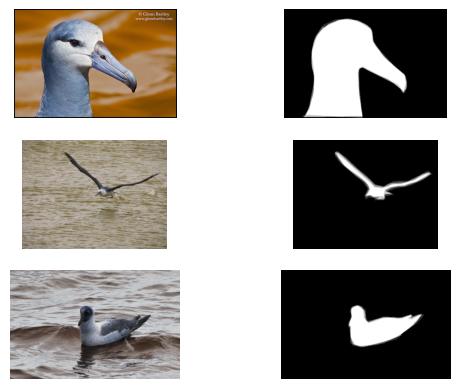

In [12]:
# Images to Feature Space
fig, axes = plt.subplots(nrows=n_class, ncols=n_images*2)
plt.axis
for i in range(n_class):
  for j in range(n_images):
    img=cv2.imread(DATASET_IMAGES_DIR+selected_images[i][j])
    seg=cv2.imread(LABELS_IMAGES_DIR+selected_images_labels[i][j])
    axes[i,j].imshow(img)
    axes[i,j].axis('off')
    axes[i,j+1].imshow(seg)
    axes[i,j+1].axis('off')
    frame=pipeline(img, seg, i+1, verbose=VERBOSE)
    pre_fspace=pd.concat([pre_fspace,frame],axis=0)

In [13]:
pre_fspace.info()

<class 'pandas.core.frame.DataFrame'>
Index: 255219 entries, 0 to 92784
Columns: 257 entries, 0 to 256
dtypes: uint8(257)
memory usage: 64.5 MB


In [14]:
# Showing observation count for each class
pre_fspace.groupby(pre_fspace[FEATURE_VECTOR_LENGTH])[0].count()

256
0    191104
1     38053
2     11363
3     14699
Name: 0, dtype: int64

In [15]:
fspace = pre_fspace.copy()
if DROP_BACKGROUND:
  fspace = fspace[fspace[FEATURE_VECTOR_LENGTH] != 0]
if BALANACING_ELIMINATION:
  # Getting Balanced Feature space out of the original fspace
  fspace = fspace.groupby(fspace[FEATURE_VECTOR_LENGTH])
  fspace = fspace.apply(lambda x: x.sample(fspace.size().min()).reset_index(drop=True))
  print(fspace.groupby(fspace[FEATURE_VECTOR_LENGTH])[0].count())

256
1    11363
2    11363
3    11363
Name: 0, dtype: int64


In [16]:
# Shuffle
fspace = fspace.sample(frac=1, axis=0).reset_index(drop=True)

In [17]:
# List of features spaces per class
fspaces=[fspace[fspace[FEATURE_VECTOR_LENGTH]==i+1] for i in range(len(selected_classes))]

In [18]:
# Number of observations per class
print([len(c_fspace) for c_fspace in fspaces])

[11363, 11363, 11363]


In [19]:
# Checking separate fspaces unique labels
for c_fspace in fspaces:
  print(c_fspace[FEATURE_VECTOR_LENGTH].unique())

[1]
[2]
[3]


In [20]:
# Getting means of features for the different fspaces
fspace_means=[c_fspace.iloc[:,:-1].mean(axis=0) for c_fspace in fspaces]

In [21]:
# Getting stds of features for the different fspaces
fspace_stds=[c_fspace.iloc[:,:-1].std(axis=0) for c_fspace in fspaces]

Text(0.5, 1.0, 'Features Means for Different Classes')

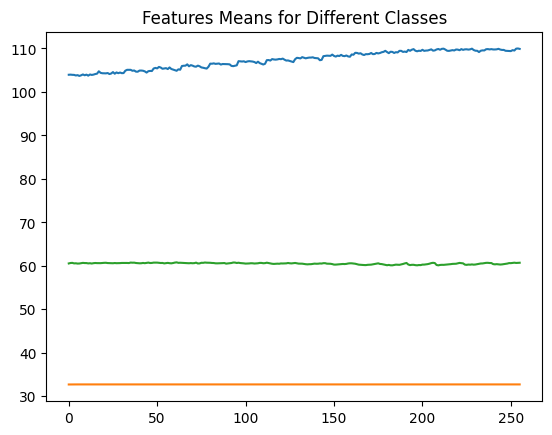

In [22]:
# Plotting classes feature means against each other
for fspace_mean in fspace_means:
  fspace_mean.plot()
plt.title('Features Means for Different Classes')

Text(0.5, 1.0, 'Features Standard Deviation For Different Classes')

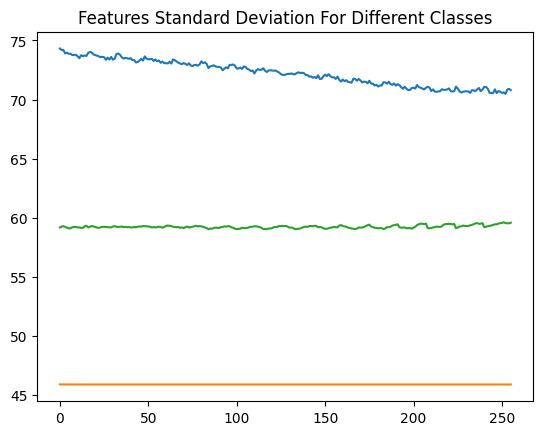

In [23]:
# Plotting features std against other classes
for fspace_std in fspace_stds:
  fspace_std.plot()
plt.title('Features Standard Deviation For Different Classes')

In [24]:
# Export the whole feature space
if EXPORT_CSV:
  fspace.to_csv('feature_space.csv', mode='w', index=False)

In [25]:
# Export feature space per class in separate csv files
if EXPORT_CSV:
  for i in range(len(DESIRED_CLASSES)+1):
    fspace[fspace[256] == i].to_csv(f'c{i}_feature_space.csv', mode='w', index=False)

In [26]:
# Split the data
train_data_x, test_data_x, train_data_y, test_data_y = train_test_split(fspace.iloc[:,:-1], fspace.iloc[:,-1], test_size=TEST_PORTION, random_state=RANDOM_STATE)
print(f'Train data shape: {train_data_x.shape}')
print(f'Train label shape: {train_data_y.shape}')
print(f'Test data shape: {test_data_x.shape}')
print(f'Test label shape: {test_data_y.shape}')

Train data shape: (27271, 256)
Train label shape: (27271,)
Test data shape: (6818, 256)
Test label shape: (6818,)


In [27]:
# Export Training data and Testing data to separate csv files
if EXPORT_CSV:
  train_data_x.to_csv('train_data.csv', mode='w', index=False)
  test_data_x.to_csv('test_data.csv', mode='w', index=False)

In [28]:
FEATURE_1 = 10
FEATURE_2 = 130

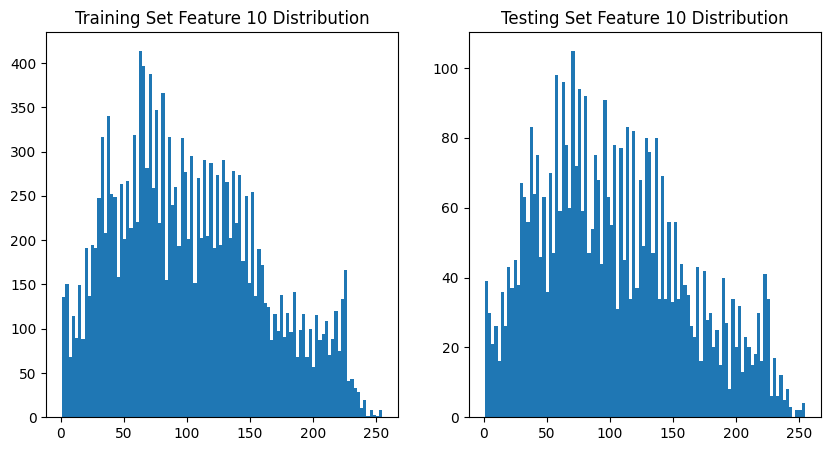

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# Plot the histograms on the two subplots
axes[0].hist(train_data_x[train_data_x != 0].iloc[:,FEATURE_1], bins=100)
axes[1].hist(test_data_x[test_data_x != 0].iloc[:,FEATURE_1], bins=100)

# Set titles and labels
axes[0].set_title(f'Training Set Feature {FEATURE_1} Distribution')
axes[1].set_title(f'Testing Set Feature {FEATURE_1} Distribution')

# Show the plots
plt.show()

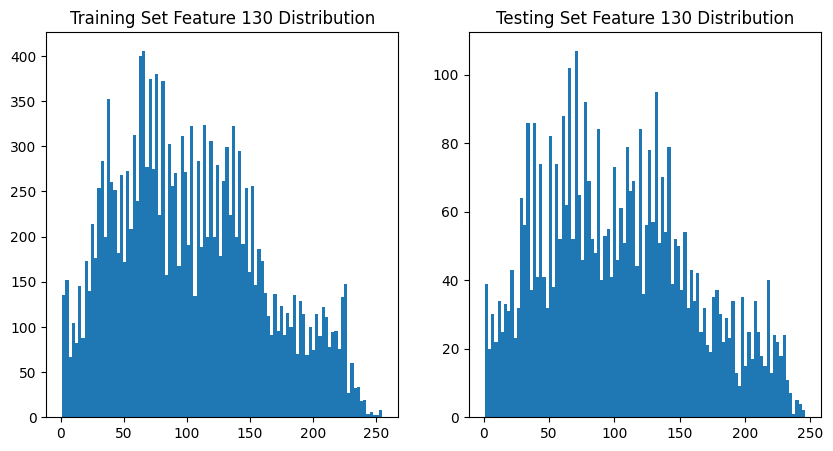

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# Plot the histograms on the two subplots
axes[0].hist(train_data_x[train_data_x != 0].iloc[:,FEATURE_2], bins=100)
axes[1].hist(test_data_x[test_data_x != 0].iloc[:,FEATURE_2], bins=100)

# Set titles and labels
axes[0].set_title(f'Training Set Feature {FEATURE_2} Distribution')
axes[1].set_title(f'Testing Set Feature {FEATURE_2} Distribution')

# Show the plots
plt.show()

In [31]:
SUBSET_SIZE=1000

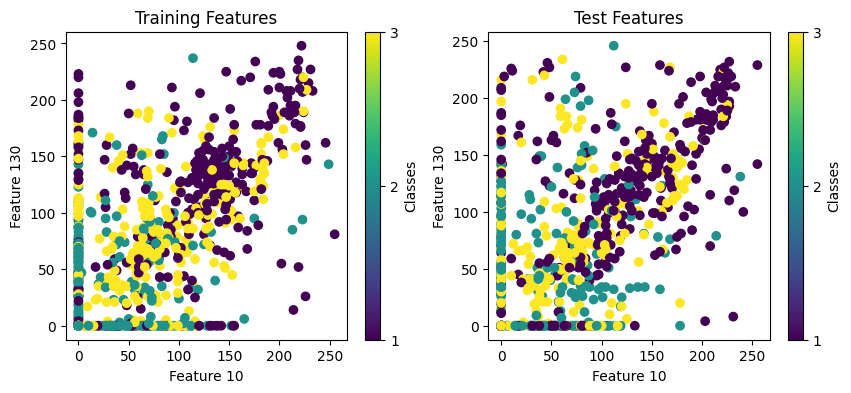

In [32]:
# Create a figure with two subplots arranged side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 4))


# Plot the first scatterplot on the first subplot
scatter1 = axes[0].scatter(train_data_x.iloc[:,FEATURE_1][:SUBSET_SIZE],
                train_data_x.iloc[:,FEATURE_2][:SUBSET_SIZE],
                c=train_data_y[:SUBSET_SIZE],
                cmap='viridis',
                marker='o')
axes[0].set_xlabel(f'Feature {FEATURE_1}')
axes[0].set_ylabel(f'Feature {FEATURE_2}')

# Plot the second scatterplot on the second subplot
scatter2 = axes[1].scatter(test_data_x.iloc[:,FEATURE_1][:SUBSET_SIZE],
                test_data_x.iloc[:,FEATURE_2][:SUBSET_SIZE],
                c=test_data_y[:SUBSET_SIZE],
                cmap='viridis',
                marker='o')
axes[1].set_xlabel(f'Feature {FEATURE_1}')
axes[1].set_ylabel(f'Feature {FEATURE_2}')

# Set titles for the subplots
axes[0].set_title('Training Features')
axes[1].set_title('Test Features')

# Add colorbars to each subplot
colorbar1 = plt.colorbar(scatter1, ax=axes[0])
colorbar2 = plt.colorbar(scatter2, ax=axes[1])
# Set labels for the colorbars
colorbar1.set_label('Classes')
colorbar2.set_label('Classes')
# Set the colorbar ticks and labels to discrete values
colorbar1.set_ticks([1, 2, 3])  # Define the tick positions
colorbar2.set_ticks([1, 2, 3])  # Define the tick positions


# Show the plots
plt.show()

In [33]:
fspace_c1_c2 = fspace[fspace[FEATURE_VECTOR_LENGTH] != 3]
fspace_c1_c3 = fspace[fspace[FEATURE_VECTOR_LENGTH] != 2]
fspace_c2_c3 = fspace[fspace[FEATURE_VECTOR_LENGTH] != 1]

In [34]:
train_data_c1_c2_x, test_data_c1_c2_x, train_data_c1_c2_y, test_data_c1_c2_y = train_test_split(fspace_c1_c2.iloc[:,:-1], fspace_c1_c2.iloc[:,-1], test_size=TEST_PORTION, random_state=RANDOM_STATE)
train_data_c1_c3_x, test_data_c1_c3_x, train_data_c1_c3_y, test_data_c1_c3_y = train_test_split(fspace_c1_c3.iloc[:,:-1], fspace_c1_c3.iloc[:,-1], test_size=TEST_PORTION, random_state=RANDOM_STATE)
train_data_c2_c3_x, test_data_c2_c3_x, train_data_c2_c3_y, test_data_c2_c3_y = train_test_split(fspace_c2_c3.iloc[:,:-1], fspace_c2_c3.iloc[:,-1], test_size=TEST_PORTION, random_state=RANDOM_STATE)

# **Task 2: Implementing a regression-based model**

In [35]:
from sklearn.linear_model import LogisticRegression


lasso_model_c1_c2 = LogisticRegression(
    penalty='l1', solver='saga', multi_class='ovr', random_state=RANDOM_STATE)

lasso_model_c1_c3 = LogisticRegression(
    penalty='l1', solver='saga', multi_class='ovr', random_state=RANDOM_STATE)

lasso_model_c2_c3 = LogisticRegression(
    penalty='l1', solver='saga', multi_class='ovr', random_state=RANDOM_STATE)

lasso_model_c123 = LogisticRegression(
    penalty='l1', solver='saga', multi_class='ovr', random_state=RANDOM_STATE)

In [36]:
lasso_model_c1_c2.fit(train_data_c1_c2_x, train_data_c1_c2_y)
lasso_model_c1_c3.fit(train_data_c1_c3_x, train_data_c1_c3_y)
lasso_model_c2_c3.fit(train_data_c2_c3_x, train_data_c2_c3_y)
lasso_model_c123.fit(train_data_x, train_data_y);

c:\Users\mosta\Workspace\UNCG - CSC-610 Big Data and Machine Learning\venv\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\mosta\Workspace\UNCG - CSC-610 Big Data and Machine Learning\venv\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\mosta\Workspace\UNCG - CSC-610 Big Data and Machine Learning\venv\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\mosta\Workspace\UNCG - CSC-610 Big Data and Machine Learning\venv\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\mosta\Workspace\UNCG - CSC-610 Big Data and Machine Learning\venv\Lib\site-pack

In [37]:
pred_c1_c2_y = lasso_model_c1_c2.predict(test_data_c1_c2_x)
pred_c1_c3_y = lasso_model_c1_c3.predict(test_data_c1_c3_x)
pred_c2_c3_y = lasso_model_c2_c3.predict(test_data_c2_c3_x)
pred_c123_y = lasso_model_c123.predict(test_data_x)

In [38]:
fspace_c1_c2_results = pd.DataFrame(test_data_c1_c2_x)
fspace_c1_c2_results[FEATURE_VECTOR_LENGTH] = test_data_c1_c2_y
fspace_c1_c2_results[FEATURE_VECTOR_LENGTH+1] = pred_c1_c2_y.round().astype(int)

fspace_c1_c3_results = pd.DataFrame(test_data_c1_c3_x)
fspace_c1_c3_results[FEATURE_VECTOR_LENGTH] = test_data_c1_c3_y
fspace_c1_c3_results[FEATURE_VECTOR_LENGTH +
                     1] = pred_c1_c3_y.round().astype(int)

fspace_c2_c3_results = pd.DataFrame(test_data_c2_c3_x)
fspace_c2_c3_results[FEATURE_VECTOR_LENGTH] = test_data_c2_c3_y
fspace_c2_c3_results[FEATURE_VECTOR_LENGTH +
                     1] = pred_c2_c3_y.round().astype(int)

fspace_c123_results = pd.DataFrame(test_data_x)
fspace_c123_results[FEATURE_VECTOR_LENGTH] = test_data_y
fspace_c123_results[FEATURE_VECTOR_LENGTH+1] = pred_c123_y.round().astype(int)

In [39]:
if EXPORT_CSV:
  fspace_c1_c2_results.to_csv('fspace_c1_c2_results.csv', mode='w', index=False)
  fspace_c1_c3_results.to_csv('fspace_c1_c3_results.csv', mode='w', index=False)
  fspace_c2_c3_results.to_csv('fspace_c2_c3_results.csv', mode='w', index=False)
  fspace_c123_results.to_csv('fspace_c123_results.csv', mode='w', index=False)

Specificity: 0.9815140845070423
False Positive Rate: 0.018485915492957746
Accuracy: 0.526616805983282
Precision: 0.6549706948234979
Recall: 0.5268168487618764


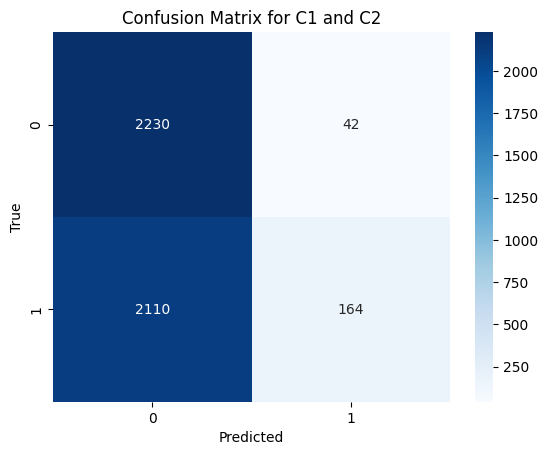

In [40]:
c1_c2_conf_matrix = confusion_matrix(fspace_c1_c2_results[FEATURE_VECTOR_LENGTH], fspace_c1_c2_results[FEATURE_VECTOR_LENGTH+1])
confusion_c1_c2_df = pd.DataFrame(c1_c2_conf_matrix, columns=['Predicted C1', 'Predicted C2'], index=['True C1', 'True C2'])

if EXPORT_CSV:
  confusion_c1_c2_df.to_csv('c1_c2_lasso_confusion.csv', mode='w', index=False)

TP, TN, FP, FN = c1_c2_conf_matrix[1, 1], c1_c2_conf_matrix[0, 0], c1_c2_conf_matrix[0, 1], c1_c2_conf_matrix[1, 0]

specificity = TN / (TN + FP)
false_positive_rate = FP / (TN + FP)

print("Specificity:", specificity)
print("False Positive Rate:", false_positive_rate)

accuracy = accuracy_score(fspace_c1_c2_results[FEATURE_VECTOR_LENGTH], fspace_c1_c2_results[FEATURE_VECTOR_LENGTH+1])
precision = precision_score(
    fspace_c1_c2_results[FEATURE_VECTOR_LENGTH], fspace_c1_c2_results[FEATURE_VECTOR_LENGTH+1], average='macro')
recall = recall_score(fspace_c1_c2_results[FEATURE_VECTOR_LENGTH],
                      fspace_c1_c2_results[FEATURE_VECTOR_LENGTH+1], average='macro')

metrics['Lasso C1C2'] = {'specificity':specificity, 'falsePositiveRate': false_positive_rate ,'accuracy':accuracy, 'precision':precision, 'recall':recall}

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)


sns.heatmap(c1_c2_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for C1 and C2')
plt.show()

Specificity: 0.9290017211703959
False Positive Rate: 0.07099827882960413
Accuracy: 0.556753189617246
Precision: 0.6156378595088425
Recall: 0.5482092314222817


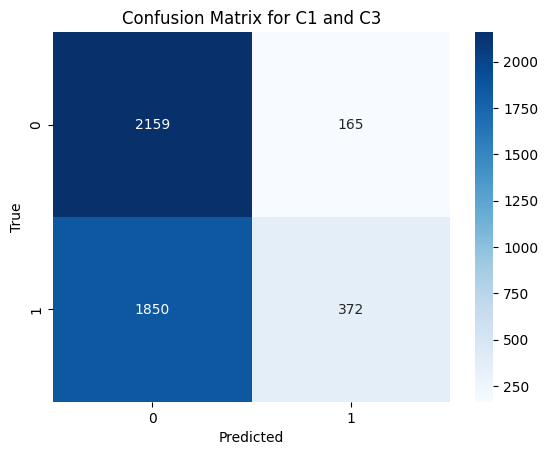

In [41]:
c1_c3_conf_matrix = confusion_matrix(fspace_c1_c3_results[FEATURE_VECTOR_LENGTH], fspace_c1_c3_results[FEATURE_VECTOR_LENGTH+1])
confusion_c1_c3_df = pd.DataFrame(c1_c3_conf_matrix, columns=['Predicted C1', 'Predicted C3'], index=['True C1', 'True C3'])
if EXPORT_CSV:
  confusion_c1_c3_df.to_csv('c1_c3_lasso_confusion.csv', mode='w', index=False)

TP, TN, FP, FN = c1_c3_conf_matrix[1, 1], c1_c3_conf_matrix[0, 0], c1_c3_conf_matrix[0, 1], c1_c3_conf_matrix[1, 0]

specificity = TN / (TN + FP)
false_positive_rate = FP / (TN + FP)

print("Specificity:", specificity)
print("False Positive Rate:", false_positive_rate)

accuracy = accuracy_score(fspace_c1_c3_results[FEATURE_VECTOR_LENGTH], fspace_c1_c3_results[FEATURE_VECTOR_LENGTH+1])
precision = precision_score(
    fspace_c1_c3_results[FEATURE_VECTOR_LENGTH], fspace_c1_c3_results[FEATURE_VECTOR_LENGTH+1], average='macro')
recall = recall_score(fspace_c1_c3_results[FEATURE_VECTOR_LENGTH],
                      fspace_c1_c3_results[FEATURE_VECTOR_LENGTH+1], average='macro')

metrics['Lasso C1C3'] = {'specificity':specificity, 'falsePositiveRate': false_positive_rate ,'accuracy':accuracy, 'precision':precision, 'recall':recall}

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

sns.heatmap(c1_c3_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for C1 and C3')
plt.show()

Specificity: 0.078294910830796
False Positive Rate: 0.921705089169204
Accuracy: 0.4964804223493181
Precision: 0.5046404739207409
Recall: 0.5013192400170892


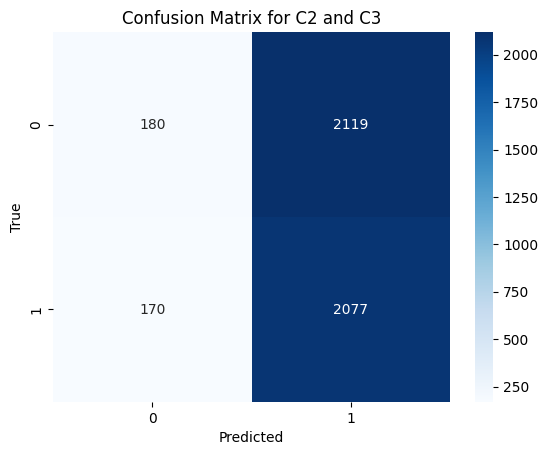

In [42]:
c2_c3_conf_matrix = confusion_matrix(fspace_c2_c3_results[FEATURE_VECTOR_LENGTH], fspace_c2_c3_results[FEATURE_VECTOR_LENGTH+1])
confusion_c2_c3_df = pd.DataFrame(c2_c3_conf_matrix, columns=['Predicted C2', 'Predicted C3'], index=['True C2', 'True C3'])
if EXPORT_CSV:
  confusion_c2_c3_df.to_csv('c2_c3_lasso_confusion.csv', mode='w', index=False)

TP, TN, FP, FN = c2_c3_conf_matrix[1, 1], c2_c3_conf_matrix[0, 0], c2_c3_conf_matrix[0, 1], c2_c3_conf_matrix[1, 0]

specificity = TN / (TN + FP)
false_positive_rate = FP / (TN + FP)

print("Specificity:", specificity)
print("False Positive Rate:", false_positive_rate)

accuracy = accuracy_score(fspace_c2_c3_results[FEATURE_VECTOR_LENGTH], fspace_c2_c3_results[FEATURE_VECTOR_LENGTH+1])
precision = precision_score(fspace_c2_c3_results[FEATURE_VECTOR_LENGTH], fspace_c2_c3_results[FEATURE_VECTOR_LENGTH+1], average='macro')
recall = recall_score(fspace_c2_c3_results[FEATURE_VECTOR_LENGTH], fspace_c2_c3_results[FEATURE_VECTOR_LENGTH+1], average='macro')

metrics['Lasso C2C3'] = {'specificity':specificity, 'falsePositiveRate': false_positive_rate ,'accuracy':accuracy, 'precision':precision, 'recall':recall}

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

sns.heatmap(c2_c3_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for C2 and C3')
plt.show()

Specificity: 0.9863325740318907
False Positive Rate: 0.01366742596810934
Accuracy: 0.3618363156350836


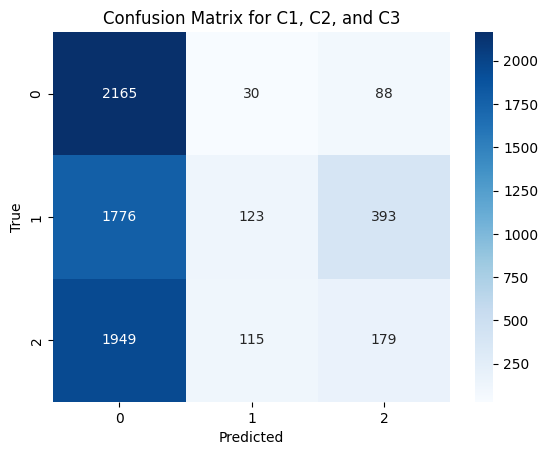

In [43]:
c123_conf_matrix = confusion_matrix(fspace_c123_results[FEATURE_VECTOR_LENGTH], fspace_c123_results[FEATURE_VECTOR_LENGTH+1])
confusion_c123_df = pd.DataFrame(c123_conf_matrix, columns=['Predicted C1', 'Predicted C2', 'Predicted C3'], index=['True C1', 'True C2', 'True C3'])

if EXPORT_CSV:
  confusion_c123_df.to_csv('c123_lasso_confusion.csv', mode='w', index=False)

TP, TN, FP, FN = c123_conf_matrix[1, 1], c123_conf_matrix[0, 0], c123_conf_matrix[0, 1], c123_conf_matrix[1, 0]

specificity = TN / (TN + FP)
false_positive_rate = FP / (TN + FP)

print("Specificity:", specificity)
print("False Positive Rate:", false_positive_rate)

accuracy = accuracy_score(fspace_c123_results[FEATURE_VECTOR_LENGTH], fspace_c123_results[FEATURE_VECTOR_LENGTH+1])

metrics['Lasso C123'] = {'specificity':specificity, 'falsePositiveRate': false_positive_rate ,'accuracy':accuracy, 'precision':None, 'recall':None}

print("Accuracy:", accuracy)

sns.heatmap(c123_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for C1, C2, and C3')
plt.show()

Text(0.5, 1.0, 'C1, C2 and C3')

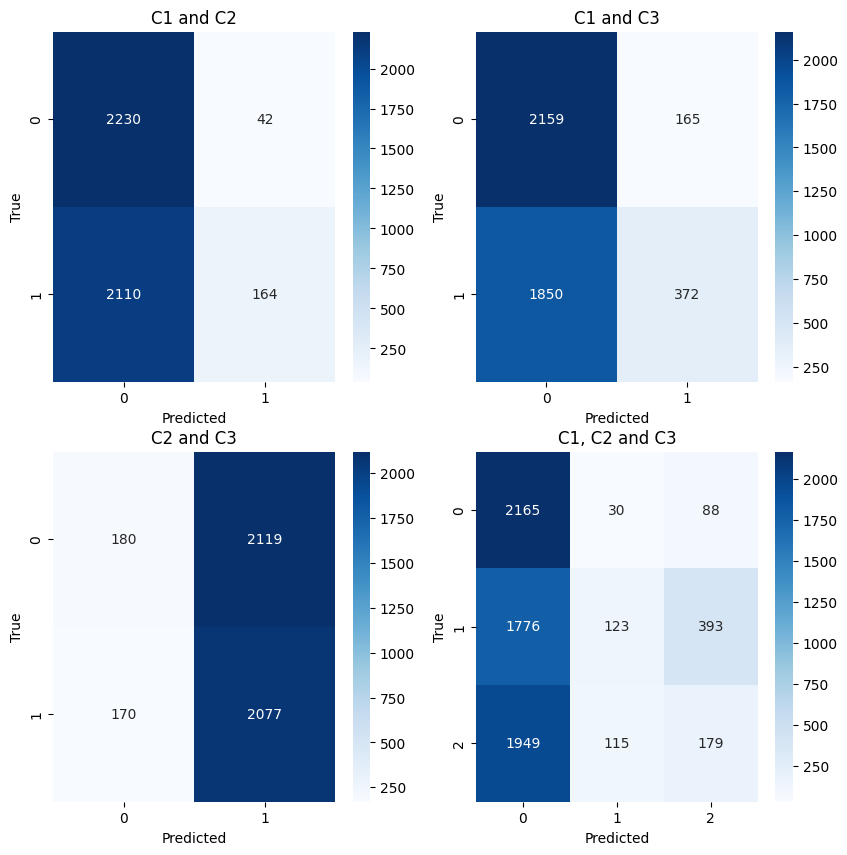

In [44]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
sns.heatmap(c1_c2_conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[0,0])
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_ylabel('True')
axes[0, 0].set_title('C1 and C2')
sns.heatmap(c1_c3_conf_matrix, annot=True,
            fmt='d', cmap='Blues', ax=axes[0, 1])
axes[0, 1].set_xlabel('Predicted')
axes[0, 1].set_ylabel('True')
axes[0, 1].set_title('C1 and C3')
sns.heatmap(c2_c3_conf_matrix, annot=True,
            fmt='d', cmap='Blues', ax=axes[1, 0])
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('True')
axes[1, 0].set_title('C2 and C3')
sns.heatmap(c123_conf_matrix, annot=True,
            fmt='d', cmap='Blues', ax=axes[1, 1])
axes[1, 1].set_xlabel('Predicted')
axes[1, 1].set_ylabel('True')
axes[1, 1].set_title('C1, C2 and C3')

# Task 3: Implementing random forest or deep learning

In [45]:
N_ESTIMATORS = 200

In [46]:
# RandomForestClassifier
rf_c1_c2_model = RandomForestClassifier(n_estimators=N_ESTIMATORS, random_state=RANDOM_STATE)
rf_c1_c3_model = RandomForestClassifier(n_estimators=N_ESTIMATORS, random_state=RANDOM_STATE)
rf_c2_c3_model = RandomForestClassifier(n_estimators=N_ESTIMATORS, random_state=RANDOM_STATE)
rf_c123_model = RandomForestClassifier(n_estimators=N_ESTIMATORS, random_state=RANDOM_STATE)

In [47]:
rf_c1_c2_model.fit(train_data_c1_c2_x, train_data_c1_c2_y)
rf_c1_c3_model.fit(train_data_c1_c3_x, train_data_c1_c3_y)
rf_c2_c3_model.fit(train_data_c2_c3_x, train_data_c2_c3_y)
rf_c123_model.fit(train_data_x, train_data_y);

In [48]:
pred_c1_c2_y = rf_c1_c2_model.predict(test_data_c1_c2_x.iloc[:,:FEATURE_VECTOR_LENGTH])
pred_c1_c3_y = rf_c1_c3_model.predict(test_data_c1_c3_x.iloc[:,:FEATURE_VECTOR_LENGTH])
pred_c2_c3_y = rf_c2_c3_model.predict(test_data_c2_c3_x.iloc[:,:FEATURE_VECTOR_LENGTH])
pred_c123_y = rf_c123_model.predict(test_data_x.iloc[:,:FEATURE_VECTOR_LENGTH])

In [49]:
fspace_c1_c2_results = pd.DataFrame(test_data_c1_c2_x)
fspace_c1_c2_results[FEATURE_VECTOR_LENGTH] = test_data_c1_c2_y
fspace_c1_c2_results[FEATURE_VECTOR_LENGTH +
                     1] = pred_c1_c2_y.round().astype(int)

fspace_c1_c3_results = pd.DataFrame(test_data_c1_c3_x)
fspace_c1_c3_results[FEATURE_VECTOR_LENGTH] = test_data_c1_c3_y
fspace_c1_c3_results[FEATURE_VECTOR_LENGTH +
                     1] = pred_c1_c3_y.round().astype(int)

fspace_c2_c3_results = pd.DataFrame(test_data_c2_c3_x)
fspace_c2_c3_results[FEATURE_VECTOR_LENGTH] = test_data_c2_c3_y
fspace_c2_c3_results[FEATURE_VECTOR_LENGTH +
                     1] = pred_c2_c3_y.round().astype(int)

fspace_c123_results = pd.DataFrame(test_data_x)
fspace_c123_results[FEATURE_VECTOR_LENGTH] = test_data_y
fspace_c123_results[FEATURE_VECTOR_LENGTH+1] = pred_c123_y.round().astype(int)

In [50]:
if EXPORT_CSV:
  fspace_c1_c2_results.to_csv('fspace_rf_c1_c2_results.csv', mode='w', index=False)
  fspace_c1_c3_results.to_csv('fspace_rf_c1_c3_results.csv', mode='w', index=False)
  fspace_c2_c3_results.to_csv('fspace_rf_c2_c3_results.csv', mode='w', index=False)
  fspace_c123_results.to_csv('fspace_rf_c123_results.csv', mode='w', index=False)

Specificity: 0.9546654929577465
False Positive Rate: 0.04533450704225352
Accuracy: 0.9696436427628684
Precision: 0.9700701387586579
Recall: 0.9696370560655048


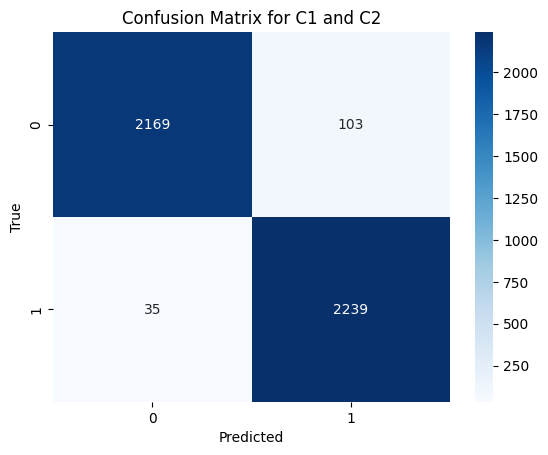

In [51]:
c1_c2_conf_matrix = confusion_matrix(fspace_c1_c2_results[FEATURE_VECTOR_LENGTH], fspace_c1_c2_results[FEATURE_VECTOR_LENGTH+1])
confusion_c1_c2_df = pd.DataFrame(c1_c2_conf_matrix, columns=['Predicted C1', 'Predicted C2'], index=['True C1', 'True C2'])

if EXPORT_CSV:
  confusion_c1_c2_df.to_csv('c1_c2_rf_confusion.csv', mode='w', index=False)

TP, TN, FP, FN = c1_c2_conf_matrix[1, 1], c1_c2_conf_matrix[0, 0], c1_c2_conf_matrix[0, 1], c1_c2_conf_matrix[1, 0]

specificity = TN / (TN + FP)
false_positive_rate = FP / (TN + FP)

print("Specificity:", specificity)
print("False Positive Rate:", false_positive_rate)

accuracy = accuracy_score(fspace_c1_c2_results[FEATURE_VECTOR_LENGTH], fspace_c1_c2_results[FEATURE_VECTOR_LENGTH+1])
precision = precision_score(
    fspace_c1_c2_results[FEATURE_VECTOR_LENGTH], fspace_c1_c2_results[FEATURE_VECTOR_LENGTH+1], average='macro')
recall = recall_score(fspace_c1_c2_results[FEATURE_VECTOR_LENGTH],
                      fspace_c1_c2_results[FEATURE_VECTOR_LENGTH+1], average='macro')

metrics['RF C1C2'] = {'specificity':specificity, 'falsePositiveRate': false_positive_rate ,'accuracy':accuracy, 'precision':precision, 'recall':recall}

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

sns.heatmap(c1_c2_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for C1 and C2')
plt.show()

Specificity: 0.9556798623063684
False Positive Rate: 0.04432013769363167
Accuracy: 0.9689837219533656
Precision: 0.969070615463618
Recall: 0.9692890760676756


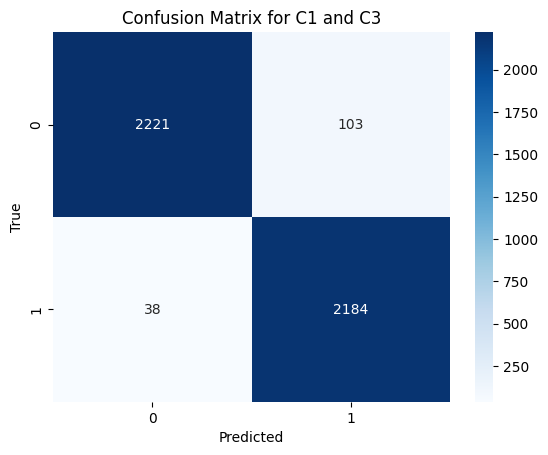

In [52]:
c1_c3_conf_matrix = confusion_matrix(fspace_c1_c3_results[FEATURE_VECTOR_LENGTH], fspace_c1_c3_results[FEATURE_VECTOR_LENGTH+1])
confusion_c1_c3_df = pd.DataFrame(c1_c3_conf_matrix, columns=['Predicted C1', 'Predicted C3'], index=['True C1', 'True C3'])
if EXPORT_CSV:
  confusion_c1_c3_df.to_csv('c1_c3_rf_confusion.csv', mode='w', index=False)

TP, TN, FP, FN = c1_c3_conf_matrix[1, 1], c1_c3_conf_matrix[0, 0], c1_c3_conf_matrix[0, 1], c1_c3_conf_matrix[1, 0]

specificity = TN / (TN + FP)
false_positive_rate = FP / (TN + FP)

print("Specificity:", specificity)
print("False Positive Rate:", false_positive_rate)

accuracy = accuracy_score(fspace_c1_c3_results[FEATURE_VECTOR_LENGTH], fspace_c1_c3_results[FEATURE_VECTOR_LENGTH+1])
precision = precision_score(
    fspace_c1_c3_results[FEATURE_VECTOR_LENGTH], fspace_c1_c3_results[FEATURE_VECTOR_LENGTH+1], average='macro')
recall = recall_score(fspace_c1_c3_results[FEATURE_VECTOR_LENGTH],
                      fspace_c1_c3_results[FEATURE_VECTOR_LENGTH+1], average='macro')

metrics['RF C1C3'] = {'specificity':specificity, 'falsePositiveRate': false_positive_rate ,'accuracy':accuracy, 'precision':precision, 'recall':recall}

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

sns.heatmap(c1_c3_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for C1 and C3')
plt.show()

Specificity: 0.9760765550239234
False Positive Rate: 0.023923444976076555
Accuracy: 0.9656841179058513
Precision: 0.9659704980000368
Recall: 0.9655638671870841


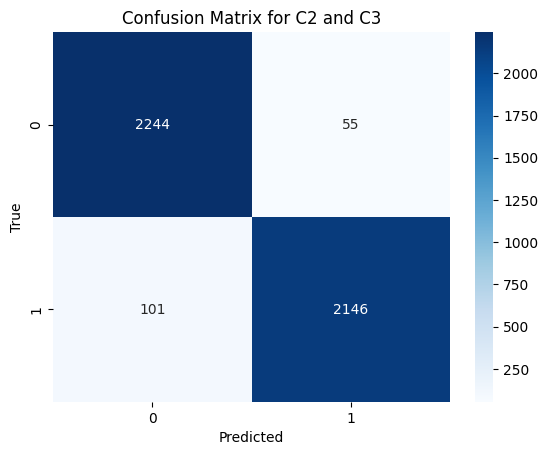

In [53]:
c2_c3_conf_matrix = confusion_matrix(fspace_c2_c3_results[FEATURE_VECTOR_LENGTH], fspace_c2_c3_results[FEATURE_VECTOR_LENGTH+1])
confusion_c2_c3_df = pd.DataFrame(c2_c3_conf_matrix, columns=['Predicted C2', 'Predicted C3'], index=['True C2', 'True C3'])
if EXPORT_CSV:
  confusion_c2_c3_df.to_csv('c2_c3_rf_confusion.csv', mode='w', index=False)


TP, TN, FP, FN = c2_c3_conf_matrix[1, 1], c2_c3_conf_matrix[0, 0], c2_c3_conf_matrix[0, 1], c2_c3_conf_matrix[1, 0]

specificity = TN / (TN + FP)
false_positive_rate = FP / (TN + FP)

print("Specificity:", specificity)
print("False Positive Rate:", false_positive_rate)

accuracy = accuracy_score(fspace_c2_c3_results[FEATURE_VECTOR_LENGTH], fspace_c2_c3_results[FEATURE_VECTOR_LENGTH+1])
precision = precision_score(fspace_c2_c3_results[FEATURE_VECTOR_LENGTH], fspace_c2_c3_results[FEATURE_VECTOR_LENGTH+1], average='macro')
recall = recall_score(fspace_c2_c3_results[FEATURE_VECTOR_LENGTH],
                      fspace_c2_c3_results[FEATURE_VECTOR_LENGTH+1], average='macro')

metrics['RF C2C3'] = {'specificity':specificity, 'falsePositiveRate': false_positive_rate ,'accuracy':accuracy, 'precision':precision, 'recall':recall}

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

sns.heatmap(c2_c3_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for C2 and C3')
plt.show()

Specificity: 0.9709618874773139
False Positive Rate: 0.029038112522686024
Accuracy: 0.9526254033440892


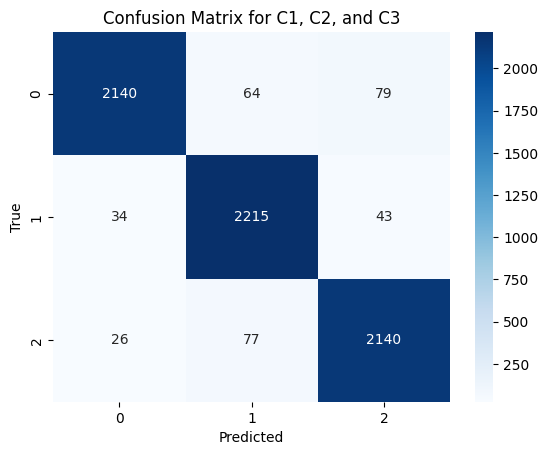

In [54]:
c123_conf_matrix = confusion_matrix(fspace_c123_results[FEATURE_VECTOR_LENGTH], fspace_c123_results[FEATURE_VECTOR_LENGTH+1])
confusion_c123_df = pd.DataFrame(c123_conf_matrix, columns=['Predicted C1', 'Predicted C2', 'Predicted C3'], index=['True C1', 'True C2', 'True C3'])

if EXPORT_CSV:
  confusion_c123_df.to_csv('c123_rf_confusion.csv', mode='w', index=False)


TP, TN, FP, FN = c123_conf_matrix[1, 1], c123_conf_matrix[0, 0], c123_conf_matrix[0, 1], c123_conf_matrix[1, 0]

specificity = TN / (TN + FP)
false_positive_rate = FP / (TN + FP)

print("Specificity:", specificity)
print("False Positive Rate:", false_positive_rate)

accuracy = accuracy_score(fspace_c123_results[FEATURE_VECTOR_LENGTH], fspace_c123_results[FEATURE_VECTOR_LENGTH+1])

metrics['RF C123'] = {'specificity':specificity, 'falsePositiveRate': false_positive_rate ,'accuracy':accuracy, 'precision':None, 'recall':None}

print("Accuracy:", accuracy)

sns.heatmap(c123_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for C1, C2, and C3')
plt.show()

Text(0.5, 1.0, 'C1, C2 and C3')

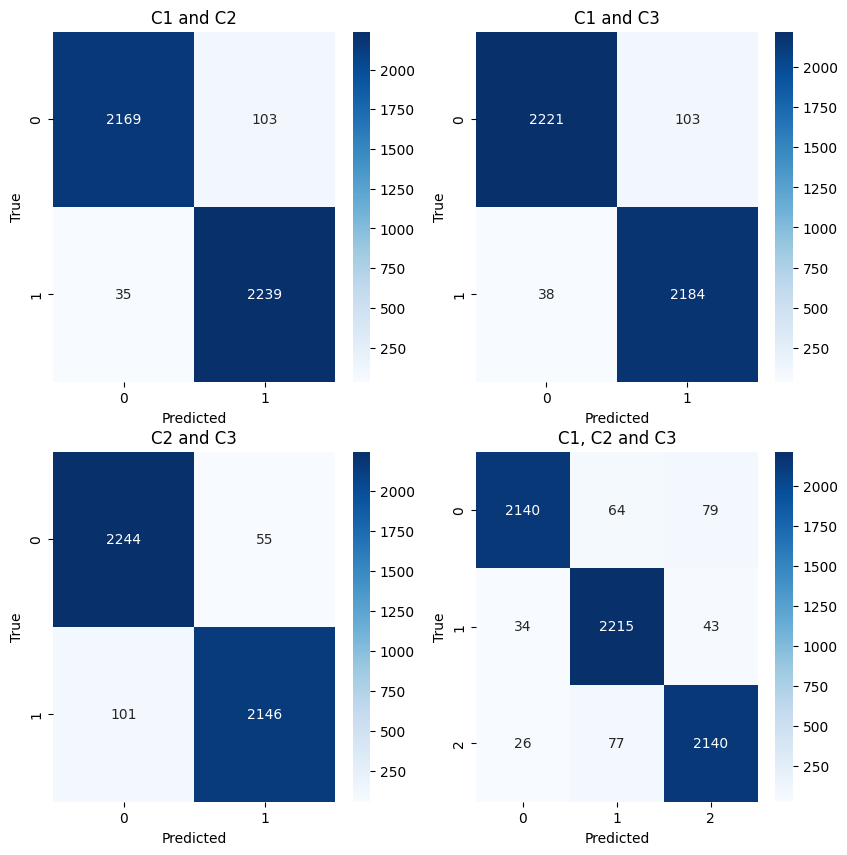

In [55]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
sns.heatmap(c1_c2_conf_matrix, annot=True,
            fmt='d', cmap='Blues', ax=axes[0, 0])
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_ylabel('True')
axes[0, 0].set_title('C1 and C2')
sns.heatmap(c1_c3_conf_matrix, annot=True,
            fmt='d', cmap='Blues', ax=axes[0, 1])
axes[0, 1].set_xlabel('Predicted')
axes[0, 1].set_ylabel('True')
axes[0, 1].set_title('C1 and C3')
sns.heatmap(c2_c3_conf_matrix, annot=True,
            fmt='d', cmap='Blues', ax=axes[1, 0])
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('True')
axes[1, 0].set_title('C2 and C3')
sns.heatmap(c123_conf_matrix, annot=True,
            fmt='d', cmap='Blues', ax=axes[1, 1])
axes[1, 1].set_xlabel('Predicted')
axes[1, 1].set_ylabel('True')
axes[1, 1].set_title('C1, C2 and C3')

In [56]:
metrics_df = pd.DataFrame(metrics).T
if EXPORT_CSV:
  metrics_df.to_csv('metrics_overview.csv', mode='w', index=False)


In [57]:
metrics_df

,specificity,falsePositiveRate,accuracy,precision,recall
Lasso C1C2,0.981514,0.018486,0.526617,0.654971,0.526817
Lasso C1C3,0.929002,0.070998,0.556753,0.615638,0.548209
Lasso C2C3,0.078295,0.921705,0.496480,0.504640,0.501319
Lasso C123,0.986333,0.013667,0.361836,NaN,NaN
RF C1C2,0.954665,0.045335,0.969644,0.970070,0.969637
RF C1C3,0.955680,0.044320,0.968984,0.969071,0.969289
RF C2C3,0.976077,0.023923,0.965684,0.965970,0.965564
RF C123,0.970962,0.029038,0.952625,NaN,NaN


In [58]:
metrics_df['accuracy']

Lasso C1C2    0.526617
Lasso C1C3    0.556753
Lasso C2C3    0.496480
Lasso C123    0.361836
RF C1C2       0.969644
RF C1C3       0.968984
RF C2C3       0.965684
RF C123       0.952625
Name: accuracy, dtype: float64

# RF C1C2 seems like a promising model, I would pick it for classifying at least between the first two classes